# RHIRL [1]

In [1]:
import numpy as np
import tensorflow as tf
from collections import defaultdict

from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Experiment 5.1

### Navigation MDP

It's defined using simple rl framework [3]. Currently available at fork: https://github.com/yrevar/simple_rl

In [2]:
np.random.seed(0)
tf.set_random_seed(0)
nvmdp = NavigationMDP(width=7, 
                        height=7, 
                        goal_locs=[(5,4)], 
                        init_loc=(1,1), 
                        rand_init=True,
                        cell_types=["empty", "yellow", "red", "green", "purple"],
                        cell_type_rewards=[0, 0, -10, -10, -10],
                        goal_reward=1.,
                        slip_prob=0.00,
                        step_cost=0.0,
                        gamma=.99)

value_iter = ValueIteration(nvmdp, sample_rate=100)
_ = value_iter.run_vi()

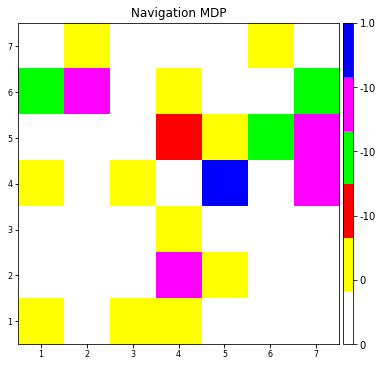

In [3]:
nvmdp.visualize_grid(nvmdp.cells)

In [4]:
def sample_data(nvmdp, n_trajectory, phi):
    """
    Args:
        n_trajectory: number of trajectories to sample

    Returns:
        [[phi(s1), phi(s3), ...], [phi(s1), phi(s3), ...], ...], where phi is one-hot encoded vector 
                of the cell type of a given state  
    """
    A_s = []
    D_mdp_states = []
    
    action_to_idx = {a:i for i,a in enumerate(nvmdp.actions)}
    
    for _ in range(n_trajectory):
        action_seq, state_seq = value_iter.plan(nvmdp.get_random_init_state())
        #print(len(action_seq), len(state_seq))
        D_mdp_states.append(state_seq)
        A_s.append([action_to_idx[a] for a in action_seq])
    return D_mdp_states, A_s

def feature_long_horizon(nvmdp, x, y):
    
    row,col = nvmdp._xy_to_rowcol(x,y)
    if (x, y) in nvmdp.goal_locs:
        return np.zeros(len(nvmdp.cell_types), dtype=np.float32)
    else:
        return np.eye(len(nvmdp.cell_types))[nvmdp.cells[row, col]]
    
def feature_short_horizon(nvmdp, x, y):
    row,col = nvmdp._xy_to_rowcol(x,y)
    return np.hstack((feature_long_horizon(nvmdp, x, y), nvmdp.feature_cell_dist[row, col]))

### Training Data: 
Set of trajectories D = $\{\tau_0, \tau_1, ..., \tau_N\}$  where  $\tau = [(s_0,a_0), (s_1,a_1), ..., (s_T,a_T)]$

In [5]:
np.random.seed(0)
N_tau = 8
phi_long=lambda mdp_state: feature_long_horizon(nvmdp, mdp_state.x, mdp_state.y)
phi_short=lambda mdp_state: feature_short_horizon(nvmdp, mdp_state.x, mdp_state.y)
D_mdp_states, A_s = sample_data(nvmdp, N_tau, phi=phi_short)

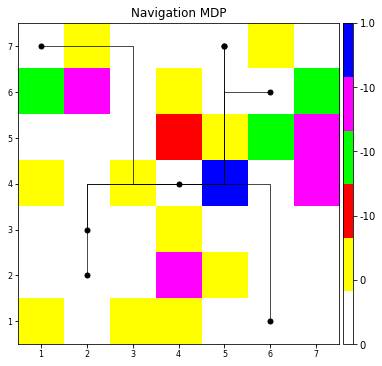

In [6]:
nvmdp.visualize_grid(trajectories=D_mdp_states)

### Features

In [7]:
def states_to_features(states, phi):
    return np.asarray([phi(s) for s in states], dtype=np.float32)

def get_h_transitions_heap(state, phi, T, actions, h):
    
    frontier = [(state, 0, 0)] # for i, a in enumerate(range(len(actions)))] # BFS frontier: [(state, heap_idx, depth), ...]
    heap = [state] # for a in range(len(actions))]
    parents = [None]
    parent_idx = [-1]
    depths = [0] # for a in range(len(actions))]
    idx = 0
    
    while len(frontier) != 0:
        
        state, heap_idx, d = frontier.pop(0)
        
        if d >= h:
            break
            
        for a in actions:
            state_prime = T(state, a)
            frontier.append((state_prime, idx+1, d+1))
            heap.append(state_prime)
            depths.append(d+1)
            parents.append(state)
            parent_idx.append(heap_idx)
            idx += 1
            
    return states_to_features(heap, phi), np.array(depths, np.int32), parents, np.asarray(parent_idx)

def get_training_data(state, phi, T, actions, h):
    
    state_feature_tree, state_depths, _, parent_idx = get_h_transitions_heap(state, phi, T, actions, h)
    next_state_marker = np.asarray([parent_idx==i for i in range(len(state_feature_tree))], dtype=np.float32)
    tf_sft = np.array([np.where(state_depths.reshape(-1,1) == i, state_feature_tree, np.zeros_like(state_feature_tree)) for i in range(h)][::-1])
    return tf_sft, state_feature_tree, state_depths, next_state_marker

### Horizon limited State Feature Tree

- Represent tree of depth h as a heap, where tree is rooted at each (s,a) of D and generated by known dynamics function. We assume R is linearly related to the features of a state so $R=f(\phi(S),W_r)$. For each visited state in the tree, we use features of that state in building the heap (called sft here).

In [8]:
gamma = 0.9999
h = 6
nA = len(nvmdp.actions)
phi = phi_short if h < 45 else phi_long
phi_s_dim = len(phi(GridWorldState(1,1)))
sft, state_feature_tree, state_depths, next_state_marker = get_training_data(D_mdp_states[0][0], phi, nvmdp.transition_func, nvmdp.actions, h)
heap_size = len(state_depths)

### RHIRL using TensorFlow Static Graph
This is inspired from [2]

In [9]:
tf.reset_default_graph()

def ComputeValue(W_r, V, Q, Pi, V_pad, sft, i):
    
    Phi_S = tf.gather(sft, i) # For i=0, this should give h-1 step features
    R = tf.matmul(Phi_S, W_r, name="R")
    V_prev = gamma * tf.expand_dims(V.read(i, name="V_prev"), -1) # For i=0, this will read hth step values which are 0
    Q_h = tf.squeeze(tf.add(R, tf.multiply(gamma, V_prev), name="Q"))
    Q_h = tf.reshape(Q_h[1:], (-1, nA), "Q_sa_reshaped")
    Pi_h = tf.nn.softmax(Q_h, axis=-1)
    V_h = tf.reduce_sum(tf.multiply(Q_h, Pi_h), axis=-1, name="V")
    V_h = tf.squeeze(tf.pad(tf.reshape(V_h, [-1,1]), [[0, V_pad], [0, 0]], 'CONSTANT'))
    V = V.write(tf.add(i,1), V_h, name="V_update")
    Q = Q.write(tf.add(i,1), Q_h, name="Q_update")
    Pi = Pi.write(tf.add(i,1), Pi_h, name="Pi_update")
    i = tf.add(i, 1)
    return W_r, V, Q, Pi, V_pad, sft, i

def run_RHC(W_r, sft, h):
    
    V = tf.TensorArray(tf.float32, size=0, dynamic_size=True,
                             clear_after_read=False, infer_shape=False, name="V_array")
    V = V.write(0,  np.zeros(heap_size, dtype=np.float32), name="V_array_0")
    Q = tf.TensorArray(tf.float32, size=0, dynamic_size=True,
                                 clear_after_read=False, infer_shape=False, name="Q_array")
    Q = Q.write(0,  np.zeros((int(heap_size//nA), nA), dtype=np.float32), name="Q_array_0")
    Pi = tf.TensorArray(tf.float32, size=0, dynamic_size=True,
                                 clear_after_read=False, infer_shape=False, name="Pi_array")
    Pi = Pi.write(0,  np.ones((int(heap_size//nA), nA), dtype=np.float32)/nA, name="Pi_array_0")
    V_pad = tf.constant( int(( nA * (1-nA**(h))/(1-nA) ) - ( nA * (1-nA**(h-1))/(1-nA) )), dtype=tf.int32)

    loop_cond = lambda W_r, V, Q, Pi, V_pad, sft, i: tf.less(i, h-1, name="compute_value_end")
    W_r, V, Q, Pi, V_pad, sft, i = tf.while_loop(loop_cond, ComputeValue, [W_r, V, Q, Pi, V_pad, sft, 0], parallel_iterations=1, name="compute_value_loop")
    return V, Q, Pi

tf.set_random_seed(0)
tf_sft = tf.placeholder(tf.float32, name="state_feature_tree")
action_idx = tf.placeholder(tf.int32, name="action_idx")
lr = tf.placeholder(tf.float32, name="learning_rate")
# W_r = tf.get_variable("W_r", dtype=tf.float32, initializer=tf.fill((phi_s_dim, 1), 0.)) # good prior
W_r = tf.get_variable("W_r", dtype=tf.float32, initializer=tf.random_uniform((phi_s_dim, 1), 0, 0.1)) # better?
V, Q, Pi = run_RHC(W_r, tf_sft, h)
log_likelihood = -tf.log(Pi.read(h-1)[0, action_idx])
W_grad = tf.gradients(log_likelihood, W_r)
sgd = tf.train.GradientDescentOptimizer(learning_rate=lr)
adam = tf.train.AdamOptimizer(learning_rate=lr)
updateGrads = adam.apply_gradients(zip(W_grad, [W_r]))
prob_summary = tf.summary.scalar('P_s_a', Pi.read(h-1)[0, action_idx])

### Check gradients
Try to overfit the model: provide single sample and optimize over Pi(s_0, a_0)

([<matplotlib.lines.Line2D at 0x1270b09e8>],
 Text(0.5,1,'p(s_0,a)'),
 Text(0.5,0,'iter'),
 Text(0,0.5,'P'))

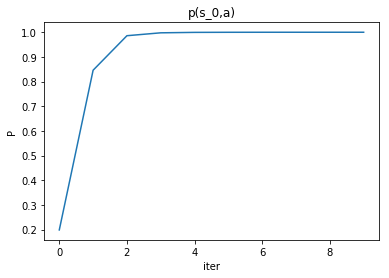

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    state_feature_tree, _, __, ___ = get_training_data(D_mdp_states[0][0], phi, nvmdp.transition_func, nvmdp.actions, h)
    feed_dict = {tf_sft: sft, action_idx: 0, lr:0.5}
    p_vals = []
    for i in range(10):
        v, q, pi, grad, ugrad = sess.run(fetches=[V.stack(), Q.stack(), Pi.stack(), W_grad, updateGrads], feed_dict=feed_dict)
        p_vals.append(pi[-1, 0, 0])
        # print(p_vals[-1])
        
plt.plot(p_vals), plt.title("p(s_0,a)"), plt.xlabel("iter"), plt.ylabel("P")

### RHIRL training

In [11]:
def compute_cell_rewards(nvmdp, w_r):
    r_map = np.zeros((nvmdp.height, nvmdp.width), dtype=np.float32)
    for row in range(nvmdp.height):
        for col in range(nvmdp.width):
            x, y = nvmdp._rowcol_to_xy(row, col)
            r_map[row, col] = feature_short_horizon(nvmdp, x, y).dot(w)[0]
    return r_map

In [12]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    merged_summary = tf.summary.merge([prob_summary])
    p_vals = defaultdict(lambda: [])
    
    cnt = 0
    for i in range(20):
        
        print("Epoch {}:".format(i))
        for t_i, traj in enumerate(D_mdp_states):

            train_writer = tf.summary.FileWriter("./rhirl/summaries/train", sess.graph)
            first_state_key = str(traj[0]) + ", a: " + str(A_s[t_i][0])
            for s_i, state in enumerate(traj[:-1]): # in last state no action is taken, so ignore

                sft, _, __, ___ = get_training_data(state, phi, nvmdp.transition_func, nvmdp.actions, h)
                feed_dict = {tf_sft: sft, action_idx: A_s[t_i][s_i], lr: 0.1}
                v, q, pi, w, grad, ugrad, summary = sess.run(
                            fetches=[V.stack(), Q.stack(), Pi.stack(), W_r, W_grad, updateGrads, merged_summary], feed_dict=feed_dict)
                if s_i == 0: p_vals[first_state_key].append(pi[-1, 0, A_s[t_i][0]])
            train_writer.add_summary(summary, cnt)
            train_writer.close()
            cnt += 1
            # Note: this only prints P(first state, first action) of each trajectory 
            print("\t P({}, a: {}): {}".format(traj[0], A_s[t_i][s_i], p_vals[first_state_key][-1]))

Epoch 0:
	 P(s: (4,4), a: 3): 0.1896396428346634
	 P(s: (2,3), a: 3): 0.3230018615722656
	 P(s: (2,2), a: 3): 0.7559819221496582
	 P(s: (1,7), a: 3): 0.10702642053365707
	 P(s: (5,7), a: 1): 0.8050296902656555
	 P(s: (6,1), a: 2): 0.8871426582336426
	 P(s: (5,7), a: 1): 0.8346546292304993
	 P(s: (6,6), a: 1): 0.6410008072853088
Epoch 1:
	 P(s: (4,4), a: 3): 0.837389349937439
	 P(s: (2,3), a: 3): 0.7596489787101746
	 P(s: (2,2), a: 3): 0.9501492977142334
	 P(s: (1,7), a: 3): 0.2866899371147156
	 P(s: (5,7), a: 1): 0.8322182893753052
	 P(s: (6,1), a: 2): 0.9560826420783997
	 P(s: (5,7), a: 1): 0.7928951382637024
	 P(s: (6,6), a: 1): 0.8279565572738647
Epoch 2:
	 P(s: (4,4), a: 3): 0.8970786929130554
	 P(s: (2,3), a: 3): 0.7782283425331116
	 P(s: (2,2), a: 3): 0.9351659417152405
	 P(s: (1,7), a: 3): 0.5895177721977234
	 P(s: (5,7), a: 1): 0.8605589270591736
	 P(s: (6,1), a: 2): 0.9581037163734436
	 P(s: (5,7), a: 1): 0.8620996475219727
	 P(s: (6,6), a: 1): 0.8549984097480774
Epoch 3:
	 P(

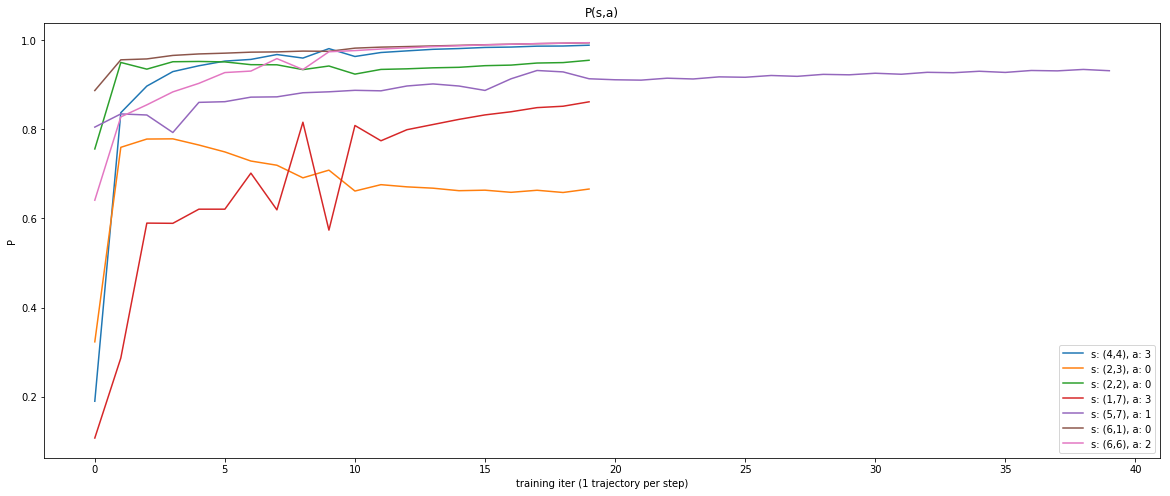

In [14]:
plt.figure(figsize=(20,8))
for k,v in p_vals.items():
    plt.plot(v, label=k)
    plt.xlabel("training iter (1 trajectory per step)")
    plt.ylabel("P")
plt.title("P(s,a)")
plt.legend()

In [15]:
len([n.name for n in tf.get_default_graph().as_graph_def().node])

9631

In [16]:
w

array([[-0.82044095],
       [-2.215041  ],
       [-7.8849077 ],
       [-4.4921627 ],
       [-4.052388  ],
       [ 0.9214518 ],
       [ 1.888573  ],
       [-1.8412327 ],
       [ 0.06379797],
       [ 1.0068028 ]], dtype=float32)

In [17]:
cell_rewards = compute_cell_rewards(nvmdp, w)

In [18]:
print("cell, true, obtained")
list(zip(["empty", "yellow", "red", "green", "purple"],[0, 0, -10, -10, -10], 
         [round(n,2) for n in np.hstack((np.eye(len(nvmdp.cell_types)), np.zeros((5,5)))).dot(w)[:,0]]))

cell, true, obtained


[('empty', 0, -0.82),
 ('yellow', 0, -2.22),
 ('red', -10, -7.88),
 ('green', -10, -4.49),
 ('purple', -10, -4.05)]

### Recovered Rewards

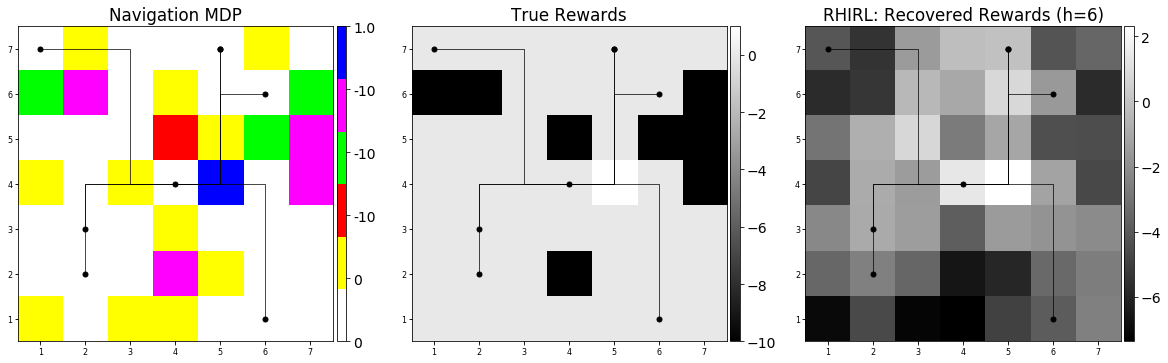

In [22]:
plt.figure(figsize=(20,12)) 
# cmap=colors.ListedColormap(['white','yellow','red','green','purple', 'blue'])
nvmdp.visualize_grid(nvmdp.cells, trajectories=D_mdp_states, 
                     subplot_str="131", new_fig=False, show_rewards_cbar=True)
nvmdp.visualize_grid(nvmdp.cell_rewards, trajectories=D_mdp_states, 
               cmap=plt.cm.gray, subplot_str="132", title="True Rewards", new_fig=False)
nvmdp.visualize_grid(cell_rewards, trajectories=D_mdp_states, 
               cmap=plt.cm.gray, subplot_str="133", new_fig=False, title="RHIRL: Recovered Rewards (h={})".format(h))

### Issues:

- Current approach adds exponential many nodes in the graph! This is disastrous for large values of h. 
- The reward function recovered is discontinuous, which is contradictory to finding. Needs further investigation.    

## Reference  
[1] MacGlashan, James, and Michael L. Littman. "Between Imitation and Intention Learning." IJCAI. 2015.  
[2] Ivan Bogatyy. A tutorial on "Efficient recursive (tree-structured) neural networks in TensorFlow." Received from: https://github.com/bogatyy/cs224d/tree/master/assignment3.  
[3] David Abel. Simple RL: "A simple framework for experimenting with Reinforcement Learning in Python." Received from: https://github.com/david-abel/simple_rl. 

## Credits  
- Prof. Michael Littman, David Abel, Jun Ki Lee, and Monica Vroman for their invaluable inputs.  
- The TF implementation is inspired from Ivan Bogatyy's recursive neural network design [2].  